0. Imports

In [1]:
import numpy as np
import os, glob, json
from typing import Tuple, Iterable
from multiprocessing import Pool, Process
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import time
import random
from random import shuffle
from sklearn.manifold import TSNE
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

In [2]:
from matplotlib import rcParamsDefault

rcParamsDefault['figure.dpi'] = 3000

1. Load 10 second data (50 per class)

In [3]:
import matplotlib.pyplot as plt
import numpy as np

def scatter_plot_tsne(tsne_result, label_vector):
    # Get the unique labels
    unique_labels = np.unique(label_vector)

    plt.subplots(figsize=(8,6))

    # Create a color map for the labels
    colors = plt.cm.get_cmap('tab10', len(unique_labels))

    # Create a scatter plot for each label
    for i, label in enumerate(unique_labels):
        # Get the indices of the rows with this label
        indices = np.where(label_vector == label)[0]

        # Get the t-SNE coordinates for these rows
        x = tsne_result[indices, 0]
        y = tsne_result[indices, 1]

        # Plot the points with the appropriate color and label
        plt.scatter(x, y, color=colors(i), label=label)

    # Add a legend and show the plot
    plt.xlabel("Component#1 [-]")
    plt.ylabel("Component#2 [-]")

    plt.legend()
    plt.show()

def getJsonFileNamesInFolder(path2jsonFiles: str) -> Iterable[str]:
    res = glob.glob(path2jsonFiles)
    return res

def parseJsonFile(filename: str, track_dict: dict) -> dict:
    # start_t = time.perf_counter()
    file = open(filename)
    content = json.load(file)
    #print(content)

    label = content["label"]
    #print(content["label"])
    if label not in track_dict:
        track_dict[label] = 0
    
    track_dict[label] = track_dict[label] + 1
    #print("number of ", label, track_dict[label])

    file.close()
    # end_t = time.perf_counter()
    return content, track_dict

def parseJsonFiles(filenames: Iterable[str], maximumNumberOfFilesPerLabel = -1) -> dict:
    start_t = time.perf_counter()
    track_dict: dict = dict()



    results = []
    #print("parseJsonFiles", filenames)
    #print("type filenames", type(filenames))

    shuffle(filenames)
    filenames_shuffled = filenames


    #print("shuffled_filenames", filenames_shuffled)

    # with Pool() as pool:
    #     results = pool.map(parseJsonFile, filenames)
    
    for filename in filenames_shuffled:
        #print("filename", filename)
        temp,track_dict = parseJsonFile(filename, track_dict)
        
        if(maximumNumberOfFilesPerLabel == -1):
            results.append(temp)

        if(track_dict[temp["label"]] <= maximumNumberOfFilesPerLabel):
            results.append(temp)

        if(len(track_dict.keys()) == 9):
            doBreak = True
            for key in track_dict:
                if track_dict[key] < maximumNumberOfFilesPerLabel:
                    doBreak = False
            if(doBreak):
                break # break as soon as each class has reached the maximum number of datapoints

        # for filename, content, duration in results:
        #     print(f"{filename} completed in {duration:.2f}s")
    end_t = time.perf_counter()
    total_duration = end_t - start_t
    print(f"etl took {total_duration:.2f}s total")
    return results

def createXandY(path2jsonFiles: str, maximumNumberOfFilesPerLabel = -1) -> Tuple[np.ndarray, np.ndarray]:
    # (filename, dict)
    jsonFilePaths : str = getJsonFileNamesInFolder(path2jsonFiles)
    print(jsonFilePaths)
    parsedFilesList = parseJsonFiles(jsonFilePaths, maximumNumberOfFilesPerLabel=maximumNumberOfFilesPerLabel)
    
    numberOfFiles = int(len(parsedFilesList))

    

    print(type(parsedFilesList[0]))
    
    
    
    sampleRate = int(parsedFilesList[0]["sampleRate"])
    durationInSeconds = int(parsedFilesList[0]["durationInSeconds"])
    datapointsPerChannel = sampleRate*durationInSeconds
    numberOfChannels = 3

    X = np.empty((numberOfFiles,datapointsPerChannel, numberOfChannels)) # (numberOfFiles, sampleRate*durationInSeconds, numberOfChannels)
    y = np.empty((numberOfFiles,),dtype=object) #(numberOfFiles, 1)

    for idx, parsedFile in enumerate(parsedFilesList):
        
        X_temp = np.empty((datapointsPerChannel, numberOfChannels))
        
        X_temp[:,0] = parsedFile["y"]
        X_temp[:,1] = parsedFile["x"]
        X_temp[:,2] = parsedFile["z"]

        X[idx] = X_temp

        y[idx] = parsedFile["label"]



    print("X:", X.shape, "y:", y.shape)
    return X,y 




In [4]:
X, y = createXandY("../data/traintest/*.json", maximumNumberOfFilesPerLabel=200)
X_eval, y_eval = createXandY("../data/evaluation/*.json", maximumNumberOfFilesPerLabel=100)

['../data/traintest/1661470457342_to_1661470578339_shape_40000_4_sampleRate_4000_durationInSeconds_10.json', '../data/traintest/1662041197516_to_1662466208815_shape_40000_4_sampleRate_4000_durationInSeconds_10.json', '../data/traintest/1663261204154_to_1663261325151_shape_40000_4_sampleRate_4000_durationInSeconds_10.json', '../data/traintest/1661436286942_to_1661436553639_shape_40000_4_sampleRate_4000_durationInSeconds_10.json', '../data/traintest/1663249043654_to_1663249164651_shape_40000_4_sampleRate_4000_durationInSeconds_10.json', '../data/traintest/1662653424850_to_1662653545847_shape_40000_4_sampleRate_4000_durationInSeconds_10.json', '../data/traintest/1661492346242_to_1661492467239_shape_40000_4_sampleRate_4000_durationInSeconds_10.json', '../data/traintest/1662483197218_to_1662483318215_shape_40000_4_sampleRate_4000_durationInSeconds_10.json', '../data/traintest/1663065600966_to_1663065721963_shape_40000_4_sampleRate_4000_durationInSeconds_10.json', '../data/traintest/16625606

etl took 46.04s total
<class 'dict'>
X: (1721, 40000, 3) y: (1721,)
['../data/evaluation/1664476721855_to_1664476842752_shape_40000_4_sampleRate_4000_durationInSeconds_10.json', '../data/evaluation/1665494723503_to_1665494844400_shape_40000_4_sampleRate_4000_durationInSeconds_10.json', '../data/evaluation/1665495933503_to_1665496054400_shape_40000_4_sampleRate_4000_durationInSeconds_10.json', '../data/evaluation/1665490488503_to_1665490609400_shape_40000_4_sampleRate_4000_durationInSeconds_10.json', '../data/evaluation/1665492303503_to_1665492424400_shape_40000_4_sampleRate_4000_durationInSeconds_10.json', '../data/evaluation/1664470308855_to_1664470429752_shape_40000_4_sampleRate_4000_durationInSeconds_10.json', '../data/evaluation/1664481924855_to_1664482045752_shape_40000_4_sampleRate_4000_durationInSeconds_10.json', '../data/evaluation/1664469219855_to_1664469340752_shape_40000_4_sampleRate_4000_durationInSeconds_10.json', '../data/evaluation/1665492424503_to_1665492545400_shape_40

### Translate german labels to english

In [5]:
np.unique(y)

array(['GLT_Rollwagen', 'Gehen', 'HebenSenken', 'Hubwagen', 'Kiste liegt',
       'Rollenbahn', 'Rolltisch', 'Sackkarre', 'vert. drehen'],
      dtype=object)

In [6]:
np.unique(y_eval)

array(['GLT_Rollwagen', 'Gehen', 'HebenSenken', 'Hubwagen', 'Kiste liegt',
       'Rollenbahn', 'Rolltisch', 'Sackkarre', 'vert. drehen'],
      dtype=object)

In [7]:
replacementDict = {"hi": 1}

In [8]:
new_values = np.array(["Large load carrier trolley","Walking","Lifting and Lowering", "Pallet jack", "Idle", "Roller conveyor", "Moving table", "Sack trolley", "Rotate horizontally"])

In [9]:
new_values

array(['Large load carrier trolley', 'Walking', 'Lifting and Lowering',
       'Pallet jack', 'Idle', 'Roller conveyor', 'Moving table',
       'Sack trolley', 'Rotate horizontally'], dtype='<U26')

In [10]:
def replace_label_values(label_vector_original, new_values):
    label_vector = np.copy(label_vector_original)
    unique_values = np.unique(label_vector)
    for i in range(len(unique_values)):
        label_vector[label_vector == unique_values[i]] = new_values[i]
        print("replaced: ", unique_values[i], " with: ", new_values[i])
    return label_vector

In [11]:
yd = replace_label_values(y, new_values)


replaced:  GLT_Rollwagen  with:  Large load carrier trolley
replaced:  Gehen  with:  Walking
replaced:  HebenSenken  with:  Lifting and Lowering
replaced:  Hubwagen  with:  Pallet jack
replaced:  Kiste liegt  with:  Idle
replaced:  Rollenbahn  with:  Roller conveyor
replaced:  Rolltisch  with:  Moving table
replaced:  Sackkarre  with:  Sack trolley
replaced:  vert. drehen  with:  Rotate horizontally


In [12]:
y_evald = replace_label_values(y_eval, new_values)

replaced:  GLT_Rollwagen  with:  Large load carrier trolley
replaced:  Gehen  with:  Walking
replaced:  HebenSenken  with:  Lifting and Lowering
replaced:  Hubwagen  with:  Pallet jack
replaced:  Kiste liegt  with:  Idle
replaced:  Rollenbahn  with:  Roller conveyor
replaced:  Rolltisch  with:  Moving table
replaced:  Sackkarre  with:  Sack trolley
replaced:  vert. drehen  with:  Rotate horizontally


In [13]:
import pandas as pd

In [14]:
def create_dataframe(y, yd, y_eval, y_evald):
    df = pd.DataFrame({
        'y': y[:100],
        'yd': yd[:100],
        'y_eval': y_eval[:100],
        'y_evald': y_evald[:100]
    })
    return df

In [15]:
replacementTestDF = create_dataframe(y, yd, y_eval, y_evald)

In [16]:
replacementTestDF

,y,yd,y_eval,y_evald
0,Rolltisch,Moving table,HebenSenken,Lifting and Lowering
1,Kiste liegt,Idle,Rolltisch,Moving table
2,Gehen,Walking,HebenSenken,Lifting and Lowering
3,HebenSenken,Lifting and Lowering,Sackkarre,Sack trolley
4,Sackkarre,Sack trolley,HebenSenken,Lifting and Lowering
...,...,...,...,...
95,HebenSenken,Lifting and Lowering,HebenSenken,Lifting and Lowering
96,Rollenbahn,Roller conveyor,Sackkarre,Sack trolley
97,GLT_Rollwagen,Large load carrier trolley,Gehen,Walking
98,HebenSenken,Lifting and Lowering,Rollenbahn,Roller conveyor


In [17]:
y = replace_label_values(y, new_values)
y_eval = replace_label_values(y_eval, new_values)

replaced:  GLT_Rollwagen  with:  Large load carrier trolley
replaced:  Gehen  with:  Walking
replaced:  HebenSenken  with:  Lifting and Lowering
replaced:  Hubwagen  with:  Pallet jack
replaced:  Kiste liegt  with:  Idle
replaced:  Rollenbahn  with:  Roller conveyor
replaced:  Rolltisch  with:  Moving table
replaced:  Sackkarre  with:  Sack trolley
replaced:  vert. drehen  with:  Rotate horizontally
replaced:  GLT_Rollwagen  with:  Large load carrier trolley
replaced:  Gehen  with:  Walking
replaced:  HebenSenken  with:  Lifting and Lowering
replaced:  Hubwagen  with:  Pallet jack
replaced:  Kiste liegt  with:  Idle
replaced:  Rollenbahn  with:  Roller conveyor
replaced:  Rolltisch  with:  Moving table
replaced:  Sackkarre  with:  Sack trolley
replaced:  vert. drehen  with:  Rotate horizontally


2. Remove outliers

In [18]:
def deleteOutliers(X, y):
    badIndices = findIllogicalValues(X, threshold=100)

    X = np.delete(X, badIndices, axis=0)
    y = np.delete(y, badIndices, axis=0)
    print("X:", X.shape, "y:", y.shape)
    return X, y
    

def findIllogicalValues(arr,threshold):    
    indices = []
    
    for idx, recording in enumerate(arr):
        flag = False
        for datapoint in recording: 
            for i, channel in enumerate(datapoint):                
                temp = channel
                if (abs(temp) > threshold):                    
                    flag = True
        if(flag):
            indices.append(idx)
    return indices

In [19]:
X, y = deleteOutliers(X, y)
X_eval, y_eval = deleteOutliers(X_eval, y_eval)

X: (1717, 40000, 3) y: (1717,)
X: (405, 40000, 3) y: (405,)


3. Apply low-pass filter

In [20]:
import numpy as np
from scipy import signal
def applyLowPassFilter(X):
    # set the filter parameters
    fs = 4000  # sampling frequency in Hz
    fc = 1100  # cutoff frequency in Hz
    order = 4  # filter order

    # calculate the filter coefficients
    b, a = signal.butter(order, fc / (fs / 2), 'low')

    # apply the filter to each recording of acceleration data
    filtered_accel_data = np.zeros_like(X)

    for i in range(X.shape[0]):
        filtered_accel_data[i,:,:] = signal.filtfilt(b, a, X[i,:,:], axis=0)
    print("X:", X.shape)
    return filtered_accel_data

In [21]:
X = applyLowPassFilter(X)
X_eval = applyLowPassFilter(X_eval)

X: (1717, 40000, 3)
X: (405, 40000, 3)


3.5 Tsne -Plot

In [22]:
X_embedded = TSNE(n_components=2, init='random', n_jobs=-1, perplexity=5).fit_transform(X[:,:,2])

In [23]:
X_eval_embedded = TSNE(n_components=2, init='random', n_jobs=-1, perplexity=5).fit_transform(X_eval[:,:,2])

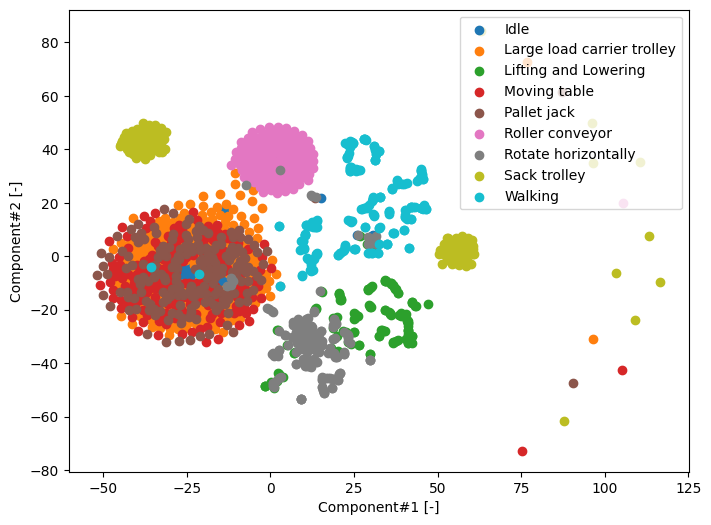

In [24]:
scatter_plot_tsne(X_embedded, y)

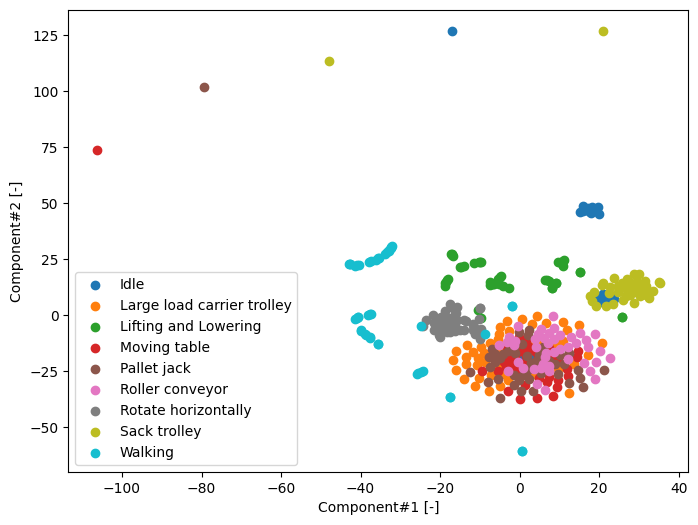

In [25]:
scatter_plot_tsne(X_eval_embedded, y_eval)

4. feature engineering => extract features based on the everywhereml-library's second order

In [26]:
import numpy as np
from scipy.stats import skew, kurtosis

def extract_features(accel_data):
    # Initialize the result array with zeros
    num_recordings = accel_data.shape[0]
    num_axes = 3
    num_features = 20
    features = np.zeros((num_recordings, num_axes, num_features))

    # Calculate the features for each axis and recording separately
    for recording in range(num_recordings):
        recording_data = accel_data[recording]

        for axis in range(num_axes):
            axis_data = recording_data[:, axis]

            max_value = np.max(axis_data)
            min_value = np.min(axis_data)
            abs_max_value = np.max(np.abs(axis_data))
            abs_min_value = np.min(np.abs(axis_data))
            mean_value = np.mean(axis_data)
            abs_energy_value = np.sum(np.square(axis_data))
            mean_abs_change_value = np.mean(np.abs(np.diff(axis_data)))
            cid_ce_value = np.sum(np.abs(np.diff(axis_data))) / (np.sum(np.abs(axis_data)) + 1e-9)
            std_value = np.std(axis_data)
            var_value = np.var(axis_data)
            count_above_mean_value = np.sum(axis_data > mean_value)
            count_below_mean_value = np.sum(axis_data < mean_value)
            first_position_of_max_value = np.argmax(axis_data)
            first_position_of_min_value = np.argmin(axis_data)
            max_count_value = np.sum(axis_data == max_value)
            min_count_value = np.sum(axis_data == min_value)
            has_large_std_value = int(std_value > np.percentile(axis_data, 95))
            skew_value = skew(axis_data)
            kurtosis_value = kurtosis(axis_data)
            variation_coefficient_value = np.std(axis_data) / np.mean(axis_data)

            # Add the features to the result array
            features[recording, axis] = np.array([
                max_value, min_value, abs_max_value, abs_min_value, mean_value,
                abs_energy_value, mean_abs_change_value, cid_ce_value, std_value,
                var_value, count_above_mean_value, count_below_mean_value,
                first_position_of_max_value, first_position_of_min_value,
                max_count_value, min_count_value, has_large_std_value, skew_value,
                kurtosis_value, variation_coefficient_value
            ])

    # Combine the features for all three axes
    features = features.reshape(num_recordings, -1)

    # Return the features as a NumPy array
    return features

In [27]:
Xf = extract_features(X)
Xf_eval = extract_features(X_eval)

## 4.1 TSN-E

In [28]:
from sklearn.manifold import TSNE

In [29]:
Xf_embedded = TSNE(n_components=2, init='random', n_jobs=-1, perplexity=5).fit_transform(Xf)

In [30]:
Xf_eval_embedded = TSNE(n_components=2, init='random', n_jobs=-1, perplexity=5).fit_transform(Xf_eval)

In [31]:
Xf_embedded.shape

(1717, 2)

In [32]:
y.shape

(1717,)

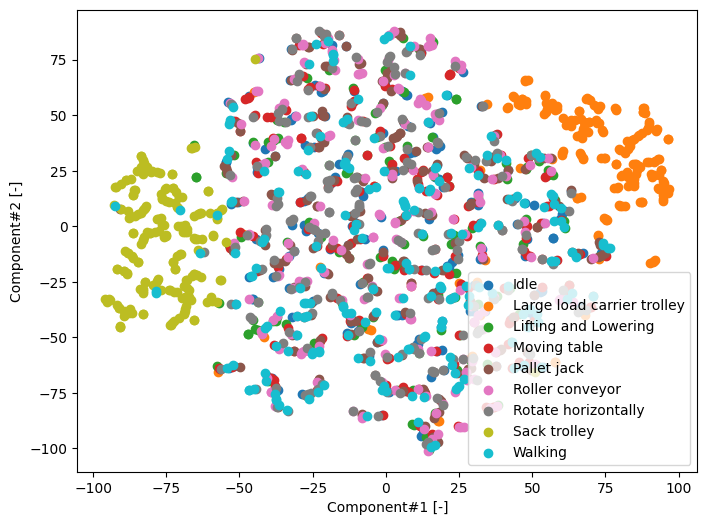

In [33]:
scatter_plot_tsne(Xf_embedded, y)

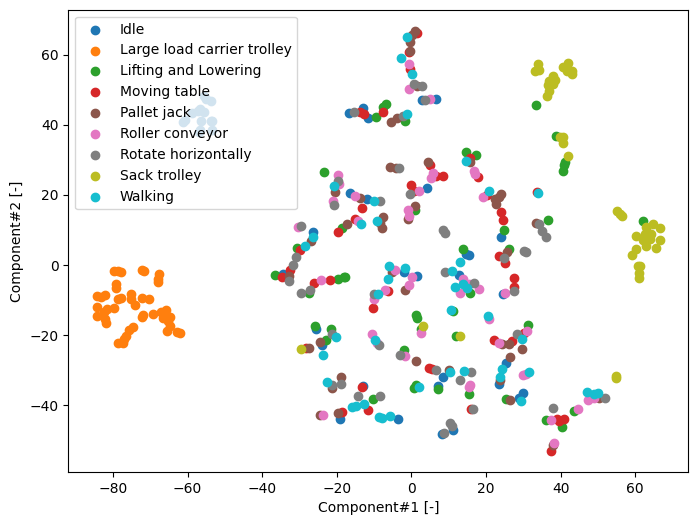

In [34]:
scatter_plot_tsne(Xf_eval_embedded, y_eval)

4.5 One-Hot encoder

In [35]:
np.unique(y)

array(['Idle', 'Large load carrier trolley', 'Lifting and Lowering',
       'Moving table', 'Pallet jack', 'Roller conveyor',
       'Rotate horizontally', 'Sack trolley', 'Walking'], dtype=object)

In [36]:
np.unique(y_eval)

array(['Idle', 'Large load carrier trolley', 'Lifting and Lowering',
       'Moving table', 'Pallet jack', 'Roller conveyor',
       'Rotate horizontally', 'Sack trolley', 'Walking'], dtype=object)

In [37]:
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(y.reshape(-1,1))

OneHotEncoder(handle_unknown='ignore')

In [38]:
enc.transform([["Rotate horizontally"]]).toarray()

array([[0., 0., 0., 0., 0., 0., 1., 0., 0.]])

In [39]:
yf=y#enc.transform(y.reshape(-1,1)).toarray()
yf_eval = y_eval#enc.transform(y_eval.reshape(-1,1)).toarray()

5. Create the train-test-split (30%)

In [40]:
X_train, X_test, y_train, y_test = train_test_split(Xf, yf, stratify=yf, test_size=0.3, random_state=42)

In [41]:
print(X_train.shape, X_test.shape)

(1201, 60) (516, 60)


6. Train (RandomForest-) Classifier [AutoML]

In [42]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import f1_score

In [43]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    return rmse, mae, r2

In [44]:
clf = RandomForestClassifier(n_estimators=20, max_depth=20, n_jobs=-1)

In [45]:
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, n_estimators=20, n_jobs=-1)

In [46]:
clf.score(X_test, y_test)

0.9903100775193798

In [47]:
clf.classes_

array(['Idle', 'Large load carrier trolley', 'Lifting and Lowering',
       'Moving table', 'Pallet jack', 'Roller conveyor',
       'Rotate horizontally', 'Sack trolley', 'Walking'], dtype=object)

In [48]:
clfx = RandomForestClassifier(n_estimators=20, max_depth=20, n_jobs=-1)
clfx.fit(Xf, yf)

RandomForestClassifier(max_depth=20, n_estimators=20, n_jobs=-1)

In [49]:
clfx.score(Xf_eval, yf_eval)

0.9629629629629629

In [50]:
import mlflow
mlflow.set_tracking_uri("http://aiserver.tzp.haw-landshut.de:5050")

In [51]:
bestF1_score = -1
bestModel = None

In [52]:
n_jobs = -1
from mlflow.models.signature import infer_signature
mlflow.set_experiment("RandomForestClassifier_paper_xyswitch")
experiment = mlflow.get_experiment_by_name("RandomForestClassifier_paper_xyswitch")
def run_model(n_estimators, max_depth, max_features, bestF1_score, bestModel):
    with mlflow.start_run() as run:
        max_features = max_features +1

        clfx_opt = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, n_jobs=n_jobs, max_features=max_features)
        clfx_opt.fit(Xf, yf)
        predicted_labels = clfx_opt.predict(Xf_eval)
        
        y_true = yf_eval
        y_pred = predicted_labels

        # (rmse, mae, r2)= eval_metrics(y_true, y_pred)
        # print((rmse, mae, r2))
        f1_score_macro = f1_score(y_true, y_pred, average='macro')

        if(f1_score_macro > bestF1_score):
            bestF1_score = f1_score_macro
            bestModel = clfx

        print(n_estimators, max_depth, max_features, "f1_score_macro", f1_score_macro)
        f1_score_micro = f1_score(y_true, y_pred, average='micro')
        f1_score_weighted = f1_score(y_true, y_pred, average='weighted')
        #f1_score_average_none = f1_score(y_true, y_pred, average='None')
        mlflow.log_param("n_estimators", n_estimators)
        mlflow.log_param("max_depth", max_depth)
        mlflow.log_param("n_jobs", n_jobs)
        mlflow.log_param("max_features", max_features)
        # mlflow.log_metric("rmse", rmse)
        # mlflow.log_metric("r2", r2)
        # mlflow.log_metric("mae", mae)

        mlflow.log_metric("f1_score_macro", f1_score_macro)
        mlflow.log_metric("f1_score_micro", f1_score_micro)
        mlflow.log_metric("f1_score_weighted", f1_score_weighted)
        mlflow.log_metric("n_classes_", clfx.n_classes_)
        mlflow.log_metric("n_features_n", clfx.n_features_)
        
        #mlflow.log_metric("f1_score_average_none", f1_score_none)

        signature = infer_signature(Xf_eval, clfx.predict(Xf_eval))
        mlflow.sklearn.log_model(clfx, "randomForest",signature=signature)
        return (run.info.experiment_id, run.info.run_id, bestF1_score, bestModel)

2023/06/15 13:49:24 INFO mlflow.tracking.fluent: Experiment with name 'RandomForestClassifier_paper_xyswitch' does not exist. Creating a new experiment.


In [53]:
Xf.shape[1]

60

In [54]:
for n_estimators in np.arange(start=1, stop=22, step=3):
    for max_depth in np.arange(start=1, stop=22, step=3):
        for max_features in np.arange(start=0, stop=Xf.shape[1], step=10):
            _, _, bestF1_score, bestModel = run_model(n_estimators=n_estimators, max_depth=max_depth, max_features=max_features, bestF1_score=bestF1_score, bestModel=bestModel)

1 1 1 f1_score_macro 0.08847706301836432


/usr/local/lib/python3.8/dist-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


1 1 11 f1_score_macro 0.1358024691358025
1 1 21 f1_score_macro 0.07967307967307967
1 1 31 f1_score_macro 0.08956228956228957
1 1 41 f1_score_macro 0.1358024691358025
1 1 51 f1_score_macro 0.12004656351554541
1 4 1 f1_score_macro 0.46988666592339967
1 4 11 f1_score_macro 0.5671338250005663
1 4 21 f1_score_macro 0.7938264485990623
1 4 31 f1_score_macro 0.5680490356703162
1 4 41 f1_score_macro 0.5500935586296132
1 4 51 f1_score_macro 0.588599822198135
1 7 1 f1_score_macro 0.4894559219828792
1 7 11 f1_score_macro 0.9101074326589791
1 7 21 f1_score_macro 0.8985362241529226
1 7 31 f1_score_macro 0.9753040680332652
1 7 41 f1_score_macro 0.9393086296303418
1 7 51 f1_score_macro 0.7809981309842536
1 10 1 f1_score_macro 0.7346205326082159
1 10 11 f1_score_macro 0.890168390742217
1 10 21 f1_score_macro 0.8546206917325541
1 10 31 f1_score_macro 0.879538812707592
1 10 41 f1_score_macro 0.9347514883407315
1 10 51 f1_score_macro 0.9275047674314665
1 13 1 f1_score_macro 0.5605332577883348
1 13 11 f1_s

mlflow.end_run()

In [55]:
bestF1_score

0.9901234567901235

mlflow.set_tracking_uri("http://aiserver.tzp.haw-landshut.de:5050")
mlflow.set_experiment("my-experiment-sklearn")
signature = infer_signature(X_test, clf.predict(X_test))
mlflow.sklearn.log_model(clf, "demo", signature=signature)

7. Evaluate with test data [AutoML]

8. Re-train using train- AND testdata [AutoML]

9. Evaluate with evaluation data [AutoML]

10. Create confusion matrix

In [56]:
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function plots a confusion matrix.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [57]:
# y_pred = enc.inverse_transform(clfx.predict(Xf_eval)).ravel()
# y_true = enc.inverse_transform(yf_eval).ravel()
y_pred = bestModel.predict(Xf_eval)
y_true = yf_eval

In [58]:
print(y_pred.shape, y_pred[0])
print(y_true.shape[0], y_true[0])

(405,) Lifting and Lowering
405 Lifting and Lowering


In [59]:
cm=confusion_matrix(y_true, y_pred, labels=np.unique(y))

Confusion matrix, without normalization


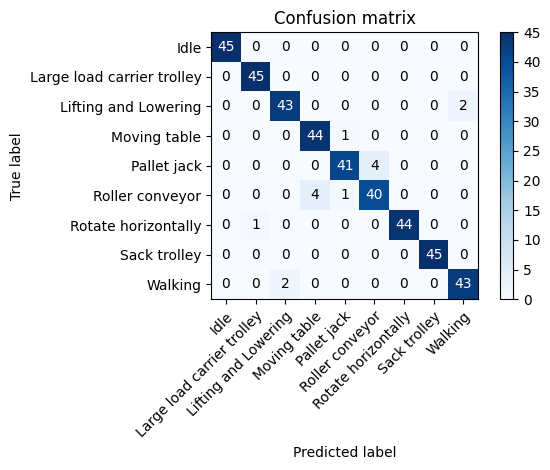

In [60]:
plot_confusion_matrix(cm,classes = np.unique(y),normalize=False)
plt.show()

In [61]:
import pandas as pd

In [62]:
df = pd.DataFrame({'True Label': y_true, 'Predicted Label': y_pred})

In [63]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(df)

                     True Label             Predicted Label
0          Lifting and Lowering        Lifting and Lowering
1                  Moving table                Moving table
2          Lifting and Lowering        Lifting and Lowering
3                  Sack trolley                Sack trolley
4          Lifting and Lowering        Lifting and Lowering
5                   Pallet jack                 Pallet jack
6               Roller conveyor             Roller conveyor
7               Roller conveyor             Roller conveyor
8           Rotate horizontally         Rotate horizontally
9                       Walking                     Walking
10                 Sack trolley                Sack trolley
11              Roller conveyor             Roller conveyor
12                  Pallet jack                 Pallet jack
13   Large load carrier trolley  Large load carrier trolley
14                 Sack trolley                Sack trolley
15                  Pallet jack         

In [64]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np

def plot_classification_report(y_true, y_pred, target_names=None, figsize=(8, 6)):
    """
    Generate a classification report and plot it using matplotlib.
    
    Parameters
    ----------
    y_true : array-like
        Ground truth (correct) target values.
    y_pred : array-like
        Estimated targets as returned by a classifier.
    target_names : list of str, default=None
        List of labels to index the report. If None, target_names will be set to the unique values in y_true.
    figsize : tuple of float, default=(8, 6)
        Figure size in inches in the form (width, height).
    """
    report = classification_report(y_true, y_pred, target_names=target_names, output_dict=True)
    fig, ax = plt.subplots(figsize=figsize)
    columns = ['precision', 'recall', 'f1-score', 'support']
    rows = target_names if target_names else list(report.keys())[:-1]
    cell_text = []
    for row in rows:
        cell_text.append([f"{report[row][column]:.3f}" if isinstance(report[row][column], float) else report[row][column] for column in columns])


    ax.axis('off')
    ax.table(cellText=cell_text,
             rowLabels=rows,
             colLabels=columns,
             loc='center')
    ax.set_title("Classification Report")
    plt.show()


In [65]:

np.unique(y)

array(['Idle', 'Large load carrier trolley', 'Lifting and Lowering',
       'Moving table', 'Pallet jack', 'Roller conveyor',
       'Rotate horizontally', 'Sack trolley', 'Walking'], dtype=object)

In [66]:
new_values.tolist()

['Large load carrier trolley',
 'Walking',
 'Lifting and Lowering',
 'Pallet jack',
 'Idle',
 'Roller conveyor',
 'Moving table',
 'Sack trolley',
 'Rotate horizontally']

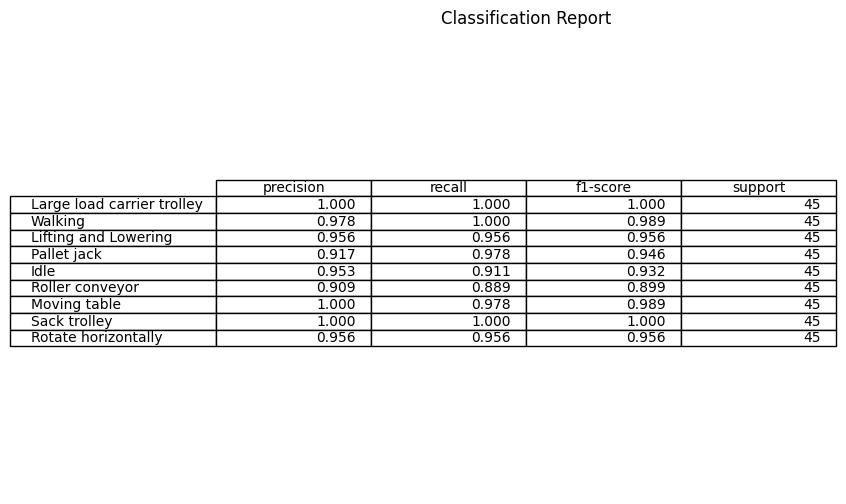

In [67]:
plot_classification_report(y_true, y_pred, target_names=new_values.tolist())

In [68]:
from sklearn.datasets import load_iris
iris = load_iris()

In [69]:
np.unique(y).astype('<U20')[0]

'Idle'

In [70]:
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

```bash
!mlflow ui
```